## Data load

In [7]:
import warnings
import pandas as pd
import numpy as np

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 경고 메시지 출력하지 않도록 설정
warnings.filterwarnings("ignore", category=Warning)

In [8]:
epsis_df = pd.read_csv('/epsis.csv',low_memory=False)
groud_df = pd.read_csv('/ground_time.csv',index_col=0)

## 5분 단위 전력수요 생성

In [9]:
import pandas as pd

epsis_df_ = epsis_df.copy()

start_date = pd.to_datetime('2023-03-13 00:00')
epsis_df_['기준일시'] = pd.to_datetime(epsis_df_['기준일시'])

filtered_df = epsis_df_[epsis_df_['기준일시'] < start_date]

train_5min_df = filtered_df.loc[:,['기준일시','현재수요(MW)']]
train_5min_df = train_5min_df.rename(columns={
    '기준일시'  : '일시',
    '현재수요(MW)'  : '전력수요'
})
train_5min_df = train_5min_df.dropna()
train_5min_df = train_5min_df.reset_index().iloc[:,1:]
train_5min_df['전력수요'] = train_5min_df['전력수요'].apply(lambda x: int(str(x).replace(',', '').split('.')[0]) if isinstance(x, str) else int(x))
train_5min_df

,일시,전력수요
0,2012-06-01 00:00:00,51726
1,2012-06-01 00:05:00,51342
2,2012-06-01 00:10:00,51583
3,2012-06-01 00:15:00,51631
4,2012-06-01 00:20:00,51252
...,...,...
1131807,2023-03-12 23:35:00,60235
1131808,2023-03-12 23:40:00,60107
1131809,2023-03-12 23:45:00,59726
1131810,2023-03-12 23:50:00,59486


## 라벨생성

In [10]:
import pandas as pd

epsis_df_ = epsis_df.copy()

start_date = pd.to_datetime('2023-03-13 00:00')
epsis_df_['기준일시'] = pd.to_datetime(epsis_df_['기준일시'])

filtered_df = epsis_df_[epsis_df_['기준일시'] >= start_date]

label_5min_df = filtered_df.loc[:,['기준일시','현재수요(MW)']]
label_5min_df = label_5min_df.rename(columns={
    '기준일시'  : '일시',
    '현재수요(MW)'  : 'label'
})
label_5min_df = label_5min_df.reset_index().iloc[:,1:]
label_5min_df = label_5min_df.dropna()
label_5min_df = label_5min_df.reset_index().iloc[:,1:]
label_5min_df['label'] = label_5min_df['label'].apply(lambda x: int(str(x).replace(',', '').split('.')[0]) if isinstance(x, str) else int(x))
label_5min_df = label_5min_df[:2016]

label_1hour_df = label_5min_df[label_5min_df['일시'].dt.minute == 0]
label_1hour_df = label_1hour_df.reset_index().iloc[:,1:]
label_1hour_df = label_1hour_df.dropna()
label_1hour_df['label'] = label_1hour_df['label'].apply(lambda x: int(str(x).replace(',', '').split('.')[0]) if isinstance(x, str) else int(x))
label_1hour_df = label_1hour_df[:168]
label_1hour_df

,일시,label
0,2023-03-13 00:00:00,58782
1,2023-03-13 01:00:00,56858
2,2023-03-13 02:00:00,54867
3,2023-03-13 03:00:00,54328
4,2023-03-13 04:00:00,54297
...,...,...
163,2023-03-19 19:00:00,60558
164,2023-03-19 20:00:00,60703
165,2023-03-19 21:00:00,60076
166,2023-03-19 22:00:00,59886


## merge

In [11]:
# 2012-01-01 00:00:00 -> 2012-01-01 00:00 : 초 없애기
groud_df['기준일시'] = groud_df['기준일시'].apply(lambda x : x[:-3])

# 기준일시 범위 맞추기
'''
- groud
  - 단위 : 1시간
  - 시작 : 2012-01-01 00:00 -> `2012-06-01 00:00`
  - 끝 : `2023-03-12 23:00`

- epsis
  - 단위 : 5분
  - 시작 : `2012-06-01 00:00`
  - 끝 : 2023-06-11 23:55      -> `2023-03-12 23:55	`
'''
groud_df2 = groud_df.iloc[groud_df[groud_df['기준일시']== '2012-06-01 00:00'].index[0]:-1]
epsis_df2 = epsis_df.iloc[:epsis_df[epsis_df['기준일시']== '2023-03-13 00:00'].index[0]]

# 데이터프레임 병합
merged_df_5 = pd.merge(epsis_df2, groud_df2, on='기준일시', how='left')
merged_df_60 = pd.merge(epsis_df2, groud_df2, on='기준일시')

## 전처리

### 컬럼 삭제

In [12]:
r_c_l = ['공급능력(MW)', '최대예측수요(MW)', '공급예비력(MW)', '공급예비율(퍼센트)', '운영예비력(MW)',
'운영예비율(퍼센트)', '기온', '기온 QC플래그', '강수량 QC플래그', '풍속 QC플래그', '풍향 QC플래그', '습도 QC플래그' ,
'현지기압 QC플래그', '해면기압 QC플래그',  '일조 QC플래그' , '일사 QC플래그', '지면온도 QC플래그' ,
         '지면상태(지면상태코드)', '3시간신적설(cm)', '현상번호(국내식)']

for c in r_c_l :
  del merged_df_60[c]

### 컬럼명 수정

In [13]:
new_columns = {
    '기준일시'  : '일시',
    '현재수요(MW)'  : '전력수요',
    '기온(°C)'  : '기온',
    '강수량(mm)'  : '강수량',
    '풍속(m/s)' : '풍속',
    '풍향(16방위)' : '풍향',
    '습도(%)' : '습도',
    '증기압(hPa)' : '증기압',
    '이슬점온도(°C)' : '이슬점온도',
    '현지기압(hPa)' : '현지기압',
    '해면기압(hPa)' : '해면기압',
    '일조(hr)' : '일조',
    '일사(MJ/m2)' : '일사',
    '적설(cm)' : '적설',
    '전운량(10분위)' : '전운량',
    '중하층운량(10분위)' : '중하층운량',
    '최저운고(100m )' : '최저운고',
    '시정(10m)' : '시정',
    '지면온도(°C)' : '지면온도',
    '5cm 지중온도(°C)' : '5cm지중온도',
    '10cm 지중온도(°C)' :'10cm지중온도',
    '20cm 지중온도(°C)' :'20cm지중온도',
    '30cm 지중온도(°C)' :'30cm지중온도'
}
merged_df_60 = merged_df_60.rename(columns=new_columns)

### 전력수요

#### dropna - 전력수요

In [14]:
# 결측치 있으면 제거
merged_df_60 = merged_df_60.dropna(subset=['전력수요'])
# 결측치 남아있나 확인
merged_df_60[merged_df_60['전력수요'].isna()==True]

,일시,전력수요,기온,강수량,풍속,풍향,습도,증기압,이슬점온도,현지기압,...,적설,전운량,중하층운량,최저운고,시정,지면온도,5cm지중온도,10cm지중온도,20cm지중온도,30cm지중온도


#### 쉼표(,) 제거 및 type 수정

In [15]:
#merged_df_60['현재수요(MW)'] = merged_df_60['현재수요(MW)'].str.replace(',', '').astype(int)
merged_df_60['전력수요'] = merged_df_60['전력수요'].apply(lambda x: int(str(x).replace(',', '').split('.')[0]) if isinstance(x, str) else int(x))

### 일시 컬럼 분리

- 2012-06-01 00:00
  - year
  - month
  - day
  - hour
  - minute

In [16]:
# 일시 컬럼을 년도, 월, 일, 시, 분으로 분리
merged_df_60['year'] = pd.to_datetime(merged_df_60['일시']).dt.year
merged_df_60['month'] = pd.to_datetime(merged_df_60['일시']).dt.month
merged_df_60['day'] = pd.to_datetime(merged_df_60['일시']).dt.day
merged_df_60['hour'] = pd.to_datetime(merged_df_60['일시']).dt.hour
merged_df_60['minute'] = pd.to_datetime(merged_df_60['일시']).dt.minute

# 결과 출력
#merged_df_60

### 결측치

#### check

In [17]:
# 결측치 체크용 셀
for col in merged_df_60.columns:
  print(col,':\t\t', len(merged_df_60[merged_df_60[col].isnull()==True]),'(',len(merged_df_60[merged_df_60[col].isnull()==True])/len(merged_df_60)*100,')')

일시 :		 0 ( 0.0 )
전력수요 :		 0 ( 0.0 )
기온 :		 1 ( 0.0010601418469791258 )
강수량 :		 52702 ( 55.87159561949389 )
풍속 :		 0 ( 0.0 )
풍향 :		 0 ( 0.0 )
습도 :		 1 ( 0.0010601418469791258 )
증기압 :		 1 ( 0.0010601418469791258 )
이슬점온도 :		 1 ( 0.0010601418469791258 )
현지기압 :		 37 ( 0.03922524833822765 )
해면기압 :		 1 ( 0.0010601418469791258 )
일조 :		 40902 ( 43.3619218251402 )
일사 :		 41101 ( 43.57289005268905 )
적설 :		 73848 ( 78.28935511571449 )
전운량 :		 5482 ( 5.811697605139568 )
중하층운량 :		 3708 ( 3.9310059685985985 )
최저운고 :		 5934 ( 6.2908817199741325 )
시정 :		 2353 ( 2.4945137659418832 )
지면온도 :		 1 ( 0.0010601418469791258 )
5cm지중온도 :		 0 ( 0.0 )
10cm지중온도 :		 0 ( 0.0 )
20cm지중온도 :		 0 ( 0.0 )
30cm지중온도 :		 0 ( 0.0 )
year :		 0 ( 0.0 )
month :		 0 ( 0.0 )
day :		 0 ( 0.0 )
hour :		 0 ( 0.0 )
minute :		 0 ( 0.0 )


#### 1개씩 비는 데이터 처리

In [18]:
index_to_modify = 22652
col_to_modify = ['기온', '습도', '증기압', '이슬점온도', '현지기압',
                 '해면기압', '전운량', '중하층운량', '최저운고', '지면온도']

for col in col_to_modify:
  merged_df_60.at[index_to_modify, col] = (merged_df_60.at[index_to_modify-1, col] + merged_df_60.at[index_to_modify+1, col]) / 2

#### 현지기압

- 결측치 37개
- 동일 시간대 평균으로 대체

In [19]:
# 같은 시간대(hour)의 평균을 계산하여 결측치 대체
merged_df_60['현지기압'] = merged_df_60.groupby('hour')['현지기압'].transform(lambda x: x.fillna(x.mean()))

In [20]:
# 확아ㅣㄴ
merged_df_60['현지기압'].isna().sum()

0

#### 강수량

1. Nan -> 0
2. 강수량으로 강수여부 컬럼 생성 ( 강수량이 0 이면 False, 그 외에는 1 )
3. 강수량으로 강수_구간 컬럼 생성
  - 0 : 비안옴 ( -1 ~ 0 )
  - 1 : 조금 ( 0 ~ 1 )
  - 2 : 중간 ( 1 ~ 10 )
  - 3 : 많이 ( 10 ~ 20 )
  - 4 : 매우 많이 ( 20 ~ )

In [21]:
# 1. Nan -> 0
merged_df_60['강수량'] = merged_df_60['강수량'].fillna(0)

In [22]:
# 2. 강수량으로 강수여부 컬럼 생성 ( 강수량이 0 이면 False, 그 외에는 1 )
merged_df_60['강수여부'] = merged_df_60['강수량'].apply(lambda x : 0 if x == 0 else 1)

In [23]:
bins = [-1, 0, 1, 10, 20, float('inf')]
labels = [0, 1, 2, 3, 4]

merged_df_60['강수_구간'] = pd.cut(merged_df_60['강수량'], bins, labels=labels)

In [24]:
merged_df_60['강수_구간'].value_counts()

0    60632
1    22044
2    11532
3       99
4       20
Name: 강수_구간, dtype: int64

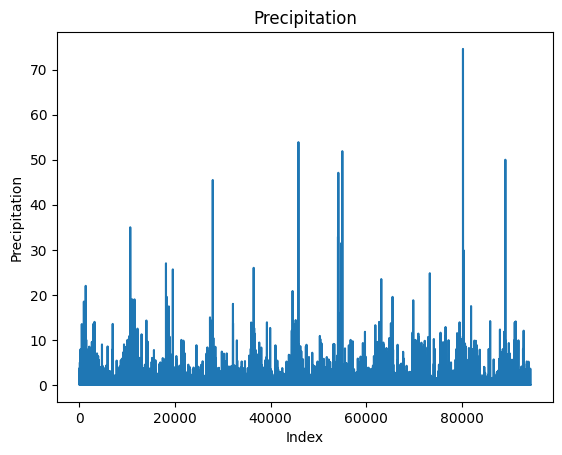

In [25]:
import matplotlib.pyplot as plt

# 강수량 데이터 시각화
plt.plot(merged_df_60['강수량'])

# 그래프 제목과 축 레이블 설정
plt.title('Precipitation')
plt.xlabel('Index')
plt.ylabel('Precipitation')

# 그래프 표시
plt.show()


#### 적설

1. Nan -> 0
2. 적설으로 적설여부 컬럼 생성 ( 적설이 0 이면 False, 그 외에는 1 )
3. 적설으로 적설_구간 컬럼 생성
  - 0 : 안옴 ( -1 ~ 0 )
  - 1 : 조금 ( 0 ~ 1 )
  - 2 : 중간 ( 1 ~ 10 )
  - 3 : 많이 ( 10 ~ 20 )
  - 4 : 매우 많이 ( 20 ~ )

In [26]:
# 1. Nan -> 0
merged_df_60['적설'] = merged_df_60['적설'].fillna(0)

In [27]:
# 2. 적설으로 적설여부 컬럼 생성 ( 적설이 0 이면 False, 그 외에는 1 )
merged_df_60['적설여부'] = merged_df_60['적설'].apply(lambda x : 0 if x == 0 else 1)

In [28]:
bins = [-1, 0, 1, 10, 20, float('inf')]
labels = [0, 1, 2, 3, 4]

merged_df_60['적설_구간'] = pd.cut(merged_df_60['적설'], bins, labels=labels)

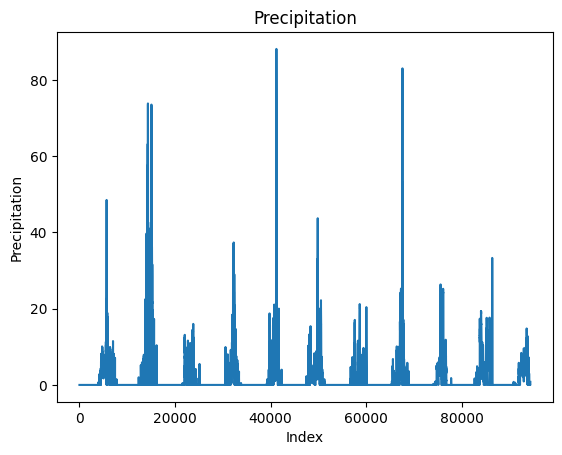

In [29]:
import matplotlib.pyplot as plt

# 강수량 데이터 시각화
plt.plot(merged_df_60['적설'])

# 그래프 제목과 축 레이블 설정
plt.title('Precipitation')
plt.xlabel('Index')
plt.ylabel('Precipitation')

# 그래프 표시
plt.show()

#### 일조, 일사

- 전력수요 와 상관관계 : 0.02, -0.02
- 제거

In [30]:
# merged_df_60['일조'].value_counts().sort_index()
merged_df_60.corr()['일사'].sort_values()['전력수요']

-0.020716741074201187

In [31]:
del merged_df_60['일조']
del merged_df_60['일사']

#### 전운량, 중하층운량, 최저운고, 시정


- 선형보간법

In [32]:
merged_df_60['전운량'] = merged_df_60['전운량'].interpolate(method='linear')
merged_df_60['중하층운량'] = merged_df_60['중하층운량'].interpolate(method='linear')
merged_df_60['최저운고'] = merged_df_60['최저운고'].interpolate(method='linear')
merged_df_60['시정'] = merged_df_60['시정'].interpolate(method='linear')

#### reset_index

In [33]:
merged_df_60.reset_index(drop=True,inplace=True)

### 정규화

In [34]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 정규화할 컬럼 선택
columns_to_normalize = ['기온', '강수량', '풍속', '풍향', '습도', '증기압', '이슬점온도', '현지기압', '해면기압',
       '적설', '전운량', '중하층운량', '최저운고', '시정', '지면온도', '5cm지중온도', '10cm지중온도',
       '20cm지중온도', '30cm지중온도']

# 정규화할 컬럼 추출
df_norm_columns = merged_df_60[columns_to_normalize]

# StandardScaler를 사용한 정규화
scaler = StandardScaler()
df_normalized_columns = pd.DataFrame(scaler.fit_transform(df_norm_columns), columns=columns_to_normalize)

# 정규화된 컬럼을 원래 데이터프레임에 할당
merged_df_60[columns_to_normalize] = df_normalized_columns

# 결과 출력
merged_df_60

,일시,전력수요,기온,강수량,풍속,풍향,습도,증기압,이슬점온도,현지기압,...,30cm지중온도,year,month,day,hour,minute,강수여부,강수_구간,적설여부,적설_구간
0,2012-06-01 00:00,51726,0.318026,0.112009,-0.840459,-0.384884,0.880137,0.354092,0.603940,0.109518,...,0.705679,2012,6,1,0,0,1,1,0,0
1,2012-06-01 01:00,50066,0.266811,-0.192657,-0.932610,-0.488512,0.981982,0.335422,0.590148,0.065090,...,0.693523,2012,6,1,1,0,1,1,0,0
2,2012-06-01 02:00,50088,0.229290,-0.340873,-0.995140,-0.467787,1.046402,0.316369,0.575399,0.046368,...,0.677792,2012,6,1,2,0,0,0,0,0
3,2012-06-01 03:00,49713,0.194464,-0.340873,-1.010499,-0.575559,1.090576,0.291690,0.556818,0.043853,...,0.673333,2012,6,1,3,0,0,0,0,0
4,2012-06-01 04:00,49968,0.161040,-0.340873,-1.099358,-0.880225,1.109595,0.261128,0.532587,0.039522,...,0.645614,2012,6,1,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94322,2023-03-12 19:00,62296,-0.803206,-0.340873,2.626270,2.000976,-0.537889,-0.870480,-0.796411,0.419116,...,-0.603839,2023,3,12,19,0,0,0,0,0
94323,2023-03-12 20:00,61978,-0.885746,-0.340873,3.074101,2.033439,-0.791345,-0.950095,-0.950026,0.554108,...,-0.610151,2023,3,12,20,0,0,0,0,0
94324,2023-03-12 21:00,60981,-0.964486,-0.184423,3.107393,2.053728,-0.982338,-1.017067,-1.100015,0.670910,...,-0.617252,2023,3,12,21,0,1,1,0,0
94325,2023-03-12 22:00,61102,-1.036577,-0.340873,3.279223,2.118654,-1.108466,-1.060880,-1.209433,0.769384,...,-0.626720,2023,3,12,22,0,0,0,0,0


### 변수선택

##### 변수 중요도

In [35]:
import pandas as pd
import xgboost as xgb

# 데이터 로드
data = merged_df_60.drop(['일시','강수_구간','적설_구간'],axis=1)

# 특성 변수와 타겟 변수 분리
X = data.drop('전력수요', axis=1)
y = data['전력수요']

# XGBoost 모델 생성 및 학습
model = xgb.XGBRegressor()
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [36]:
# 변수 중요도 계산
importance_scores = model.feature_importances_

# 변수 중요도를 기준으로 변수 선택
threshold = 0.05  # 변수 중요도의 임계값 설정
selected_variables = X.columns[importance_scores >= threshold]

# 선택된 변수 출력
print("Selected variables:", selected_variables)

Selected variables: Index(['증기압', '5cm지중온도', '10cm지중온도', 'year', 'hour'], dtype='object')


In [37]:
for k,v in zip(X.columns,importance_scores):
  print(f'{k} : {v*100}')

기온 : 3.99414524435997
강수량 : 0.4796813242137432
풍속 : 0.705358013510704
풍향 : 0.8156976662576199
습도 : 0.6477310322225094
증기압 : 7.670523226261139
이슬점온도 : 1.329336129128933
현지기압 : 0.9293208830058575
해면기압 : 1.1466975323855877
적설 : 1.8898751586675644
전운량 : 0.8658438920974731
중하층운량 : 1.135260984301567
최저운고 : 0.7633247412741184
시정 : 0.8888554759323597
지면온도 : 2.5491852313280106
5cm지중온도 : 16.245970129966736
10cm지중온도 : 20.125913619995117
20cm지중온도 : 2.4226102977991104
30cm지중온도 : 2.133137919008732
year : 7.413659989833832
month : 2.286819741129875
day : 1.5635276213288307
hour : 21.997524797916412
minute : 0.0
강수여부 : 0.0
적설여부 : 0.0


##### 불필요한 변수 제거

- 영향이 거의 없는 컬럼 제거

In [38]:
del merged_df_60['minute']
del merged_df_60['강수여부']
del merged_df_60['적설여부']

del merged_df_60['전운량']
del merged_df_60['중하층운량']
del merged_df_60['최저운고']

del merged_df_60['시정']

### 모델링

#### 1시간 모델링

In [41]:
import pickle
import statsmodels.api as sm

model = sm.tsa.VAR(data)
with open('/content/var_model.pkl', 'rb') as f:
    var_model = pickle.load(f)

In [42]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error

df_ = merged_df_60.copy()
data = df_.loc[:,['전력수요']+list(selected_variables)]

predicts = []
for i in range(168) : #
  if i % 5 == 0:
    print(f'{i}/{168}')
  # VAR 모델 생성
  #model = sm.tsa.VAR(data)
  model = var_model

  # 모델 학습
  lag_order = 24 * 14 # 14일치 데이터 학습 (24는 1시간x24 == 24시간, 14는 14일치)
  results = model.fit(lag_order)

  # 예측
  forecast = results.forecast(data.values[-lag_order:], steps = 1 ) # Step = 몇 개의 데이터를 예측할 것인지
  forecast_df = pd.DataFrame(forecast, columns = data.columns)

  # data 추가
  data = pd.concat([data,forecast_df])

  predicts.append(forecast_df['전력수요'].values[0])

0/168


TypeError: ignored

In [46]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error
import pickle
import statsmodels.api as sm

model = sm.tsa.VAR(data)
with open('/content/var_model.pkl', 'rb') as f:
    var_model = pickle.load(f)


df_ = merged_df_60.copy()
data = df_.loc[:,['전력수요']+list(selected_variables)]

predicts = []
for i in range(168) : #
  if i % 5 == 0:
    print(f'{i}/{168}')
  # VAR 모델 생성
  #model = sm.tsa.VAR(data)
  model = var_model

  # 예측
  forecast = results.forecast(data.values[-lag_order:], steps = 1 ) # Step = 몇 개의 데이터를 예측할 것인지
  forecast_df = pd.DataFrame(forecast, columns = data.columns)

  # data 추가
  data = pd.concat([data,forecast_df])

  predicts.append(forecast_df['전력수요'].values[0])

0/168


NameError: ignored

##### 모델 저장

In [ ]:
import pickle

# VAR 모델 저장
with open('var_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [43]:
import pandas as pd

# 예측 결과를 담은 DataFrame 생성
predict_df = pd.DataFrame({'predict': predicts})

# '일시' 컬럼 생성
start_time = pd.to_datetime('2023-03-13 00:00:00')
time_index = pd.date_range(start=start_time, periods=len(predict_df), freq='1H')
predict_df['일시'] = time_index

merged_df = label_5min_df.merge(predict_df, on='일시', how='left')

# 결과 저장
label_5min_df = merged_df
label_5min_df

,일시,label,predict
0,2023-03-13 00:00:00,58782,NaN
1,2023-03-13 00:05:00,58954,NaN
2,2023-03-13 00:10:00,58711,NaN
3,2023-03-13 00:15:00,58298,NaN
4,2023-03-13 00:20:00,58264,NaN
...,...,...,...
2011,2023-03-19 23:35:00,58627,NaN
2012,2023-03-19 23:40:00,57941,NaN
2013,2023-03-19 23:45:00,57726,NaN
2014,2023-03-19 23:50:00,57755,NaN


#### 5분 단위 모델링

In [44]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# 전력수요 데이터 추출
demand_data = train_5min_df['전력수요']

# 상대적인 변화량 계산
baseline = demand_data.iloc[-1]
relative_change = demand_data - baseline

# 정규화
scaler = MinMaxScaler()
relative_change_normalized = scaler.fit_transform(relative_change.values.reshape(-1, 1))

# 특성 생성
features = relative_change_normalized[:-1]
target = relative_change_normalized[1:]
print(relative_change_normalized.shape)
# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(features, target)

(1131812, 1)


LinearRegression()

##### 모델 저장

In [ ]:
import pickle

# VAR 모델 저장
with open('linear_regression_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [45]:
def predict_relative_change(model, input_value):
    # 입력 값 정규화
    input_value_normalized = scaler.transform([[input_value]])[0, 0]

    # 특정값을 기준으로한 상대적인 변화량 예측
    input_feature = [[input_value_normalized]]
    predicted_relative_change_normalized = model.predict(input_feature)

    # 역정규화
    predicted_relative_change = scaler.inverse_transform(predicted_relative_change_normalized.reshape(-1, 1))

    return predicted_relative_change

In [ ]:
last_value = label_5min_df['predict'][0]
for i, val in enumerate(label_5min_df['predict']):
  if i % 100== 0 :
    #print(i)
    pass
  if np.isnan(val):
    predicted_value = predict_relative_change(model, last_value)[0][0]
    label_5min_df.loc[i,'predict'] = predicted_value
    last_value = predicted_value
  else:
    last_value = val
label_5min_df.head(30)

,일시,label,predict
0,2023-03-13 00:00:00,58782,59431.211255
1,2023-03-13 00:05:00,58954,59401.143280
2,2023-03-13 00:10:00,58711,59371.091416
3,2023-03-13 00:15:00,58298,59341.055655
4,2023-03-13 00:20:00,58264,59311.035989
5,2023-03-13 00:25:00,58105,59281.032407
6,2023-03-13 00:30:00,57476,59251.044902
7,2023-03-13 00:35:00,57141,59221.073466
8,2023-03-13 00:40:00,56897,59191.118089
9,2023-03-13 00:45:00,56664,59161.178764


#### MAPE 시각화

MAPE :  4.35030515587399


<Figure size 1000x600 with 0 Axes>

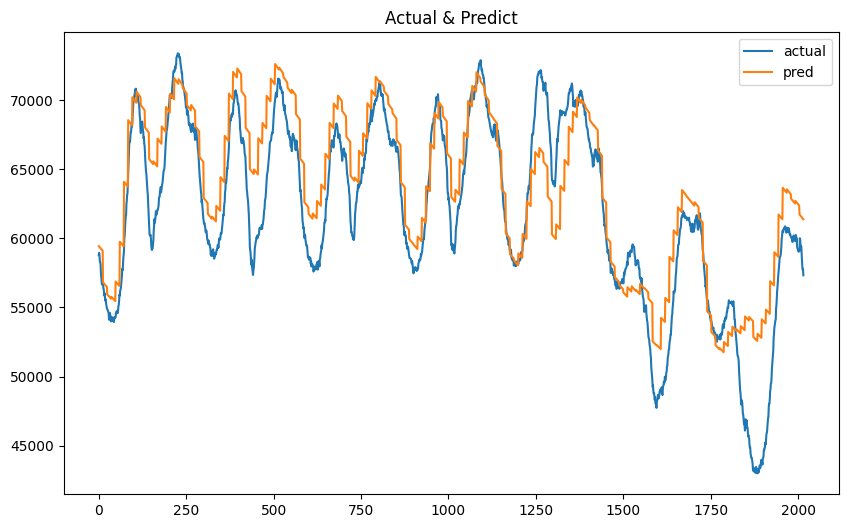

In [ ]:
def result_graph(actual, predicted):

    MAPE = np.mean(np.abs((actual - predicted) / actual)) * 100

    # MAPE 계산
    mape = [abs((a - p) / a) * 100 for a, p in zip(actual, predicted)]

    print('MAPE : ', MAPE)

    # 그래프 크기 설정
    fig = plt.figure(figsize=(10, 6))

    fig = plt.figure(figsize=(10, 6))
    plt.plot(actual, label='actual')
    plt.plot(predicted, label='pred')
    plt.title('Actual & Predict')
    plt.legend()
    plt.show()

result_graph(label_5min_df['label'],label_5min_df['predict'])